# **LAB 04 - Lập trình Spark với Python**


# Khởi tạo Spark

In [1]:
!python --version

Python 3.7.13


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
!wget -q https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz

In [4]:
!tar xzf spark-3.3.0-bin-hadoop3.tgz
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64/"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

In [6]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

spark = SparkSession \
    .builder \
    .appName("Data mining") \
    .master('local[*]')\
    .getOrCreate()

In [8]:
!wget "https://drive.google.com/uc?export=download&id=1qakfZ5h7wJzZpjdGzs7Nv0kHeMGFv-RV" -O "Lab04-Data.zip"
!unzip "/content/Lab04-Data.zip" 

--2022-07-29 19:31:10--  https://drive.google.com/uc?export=download&id=1qakfZ5h7wJzZpjdGzs7Nv0kHeMGFv-RV
Resolving drive.google.com (drive.google.com)... 142.251.16.102, 142.251.16.101, 142.251.16.139, ...
Connecting to drive.google.com (drive.google.com)|142.251.16.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6f5va630v6lks7b2q6p6e425s0033qv0/1659123000000/04407268810462350615/*/1qakfZ5h7wJzZpjdGzs7Nv0kHeMGFv-RV?e=download&uuid=30f4cd02-698d-46f4-b8eb-e433602808c9 [following]
--2022-07-29 19:31:13--  https://doc-08-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6f5va630v6lks7b2q6p6e425s0033qv0/1659123000000/04407268810462350615/*/1qakfZ5h7wJzZpjdGzs7Nv0kHeMGFv-RV?e=download&uuid=30f4cd02-698d-46f4-b8eb-e433602808c9
Resolving doc-08-58-docs.googleusercontent.com (doc-08-58-docs.googleusercontent.com)... 172.253.115.132, 2607

# **Bài 1 - Khai thác mẫu phổ biến và luật kết hợp**

**1) Đọc dữ liệu vào PySpark và tiền xử lý dữ liệu**

In [9]:
order_df = spark.read.csv("Lab04-Data/orders.csv", header='True')
products_df = spark.read.csv("Lab04-Data/products.csv", header='True')

In [10]:
order_df.printSchema()
products_df.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- add_to_cart_order: string (nullable = true)
 |-- reordered: string (nullable = true)

root
 |-- product_id: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: string (nullable = true)
 |-- department_id: string (nullable = true)



In [11]:
order_df.show(5)
products_df.show(5)

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       1|     49302|                1|        1|
|       1|     11109|                2|        1|
|       1|     10246|                3|        0|
|       1|     49683|                4|        0|
|       1|     43633|                5|        1|
+--------+----------+-----------------+---------+
only showing top 5 rows

+----------+--------------------+--------+-------------+
|product_id|        product_name|aisle_id|department_id|
+----------+--------------------+--------+-------------+
|         1|Chocolate Sandwic...|      61|           19|
|         2|    All-Seasons Salt|     104|           13|
|         3|Robust Golden Uns...|      94|            7|
|         4|Smart Ones Classi...|      38|            1|
|         5|Green Chile Anyti...|       5|           13|
+----------+--------------------+--------+-------------+
only showing

- Để thực một số phương thức tiền xử lý dữ liệu, ta sử dụng các fuctions của PySpark SQL.
- Để có thể lấy được tên các sản phẩm (products) của từng mã order ta thực hiện phép join 2 bảng có điều kiện, sử dụng <em>GroupBy</em> để thao thác trên từng order id, ứng với mỗi order id ta sử dụng phương thức <em>collect_list</em> trên thuộc tính products để tạo ra danh sách các sản phẩm.

In [12]:
from pyspark.sql import functions as f

In [13]:
df = order_df.join(products_df,order_df['product_id']==products_df['product_id'])\
      .groupBy('order_id')\
      .agg(f.collect_list('product_name').alias('products'))\
      .orderBy('order_id')\
      .select('order_id','products')

In [14]:
df.show()

+--------+--------------------+
|order_id|            products|
+--------+--------------------+
|       1|[Bulgarian Yogurt...|
|  100000|[I Heart Baby Kal...|
| 1000008|[ZzzQuil Liquid W...|
| 1000029|[Almond Chia Gran...|
|  100003|[Organic Salted B...|
| 1000046|[Organic Red Bell...|
| 1000080|[Oatneal Cookie I...|
| 1000162|[Mexican Style Ri...|
| 1000197|[Sesame Topped Ha...|
| 1000209|[Organic Super Fr...|
| 1000222|[Disinfecting Bat...|
| 1000225|[Garlic, Unsalted...|
| 1000247|[Whiskas® Temptat...|
| 1000264|[Organic 2% Reduc...|
| 1000277|[Bag of Jumbo Yel...|
| 1000293|[Uncured Pepperon...|
|  100036|[Non Fat Greek Yo...|
| 1000365|[Half & Half, Pur...|
| 1000420|[Black Seedless G...|
| 1000448|[Organic Cucumber...|
+--------+--------------------+
only showing top 20 rows



In [15]:
df.count()

131209

**2) Áp dụng giải thuật khai thác mẫu phổ biến và luật kết hợp trong gói pyspark.ml.fpm**

Khởi tạo mô hình FPGrowth của PySpark qua thư viện <em>pyspark.ml.fpm</em> và chạy trên tập dữ liệu đã tiền xử lý

In [16]:
import pyspark.ml.fpm as fpm

Khởi tạo FPGrowth với:
- minSupport = 0.01
- minConfidence = 0.01

In [17]:
fpg = fpm.FPGrowth(itemsCol='products', minSupport=0.001, minConfidence=0.01)
model = fpg.fit(df)

Lấy ra các tập phổ biến từ mô hình

In [18]:
frequent_itemsets = model.freqItemsets
frequent_itemsets.show()

+--------------------+----+
|               items|freq|
+--------------------+----+
|[White Cheddar Po...| 370|
|[Total 0% Nonfat ...| 993|
|[Total 0% Nonfat ...| 137|
|[Total 0% Nonfat ...| 157|
|[Total 0% Nonfat ...| 143|
|[Total 0% Nonfat ...| 258|
|[Organic YoKids V...| 259|
|[Organic Large Gr...| 730|
|[Organic Large Gr...| 185|
|[Organic Large Gr...| 263|
|[Organic Large Gr...| 136|
|[Organic Large Gr...| 164|
|[Organic Cream Ch...| 365|
|[Organic Reduced ...| 140|
|[Florida Orange J...| 283|
|      [Green Onions]|1445|
|[Green Onions, Li...| 206|
|[Green Onions, Or...| 133|
|[Green Onions, Bu...| 187|
|[Green Onions, La...| 229|
+--------------------+----+
only showing top 20 rows



In [19]:
frequent_itemsets.count()

4444

**Xem chi tiết các itemsets phổ biến**

In [20]:
frequent_itemsets.select('items').collect()

[Row(items=['White Cheddar Popcorn']),
 Row(items=['Total 0% Nonfat Greek Yogurt']),
 Row(items=['Total 0% Nonfat Greek Yogurt', 'Organic Avocado']),
 Row(items=['Total 0% Nonfat Greek Yogurt', 'Bag of Organic Bananas']),
 Row(items=['Total 0% Nonfat Greek Yogurt', 'Organic Baby Spinach']),
 Row(items=['Total 0% Nonfat Greek Yogurt', 'Banana']),
 Row(items=['Organic YoKids Very Berry Smoothies']),
 Row(items=['Organic Large Green Asparagus']),
 Row(items=['Organic Large Green Asparagus', 'Organic Strawberries']),
 Row(items=['Organic Large Green Asparagus', 'Bag of Organic Bananas']),
 Row(items=['Organic Large Green Asparagus', 'Organic Baby Spinach']),
 Row(items=['Organic Large Green Asparagus', 'Organic Hass Avocado']),
 Row(items=['Organic Cream Cheese Bar']),
 Row(items=['Organic Reduced Fat Omega-3 Milk']),
 Row(items=['Florida Orange Juice With Calcium & Vitamin D']),
 Row(items=['Green Onions']),
 Row(items=['Green Onions', 'Limes']),
 Row(items=['Green Onions', 'Organic Avoca

**Rút ra các bộ luật**

In [21]:
associate_rules = model.associationRules
associate_rules.show()

+--------------------+--------------------+-------------------+------------------+--------------------+
|          antecedent|          consequent|         confidence|              lift|             support|
+--------------------+--------------------+-------------------+------------------+--------------------+
|[Yellow Onions, L...|             [Limes]|0.23962516733601072|5.2114998476695895|0.001364235685052...|
|[Yellow Onions, L...|   [Organic Avocado]| 0.2101740294511379|3.7220575287156636|0.001196564260073623|
|[Yellow Onions, L...|[Organic Baby Spi...|0.19812583668005354| 2.656980059786707|0.001127971404400...|
|[Yellow Onions, L...|            [Banana]|0.34404283801874164| 2.410633169582456|0.001958707100884848|
|[Yellow Onions, B...|             [Limes]|0.14285714285714285| 3.106935663375246|0.001166078546441174|
|[Yellow Onions, B...|   [Organic Avocado]|0.17740429505135388|3.1417249493039674|0.001448071397541327|
|[Yellow Onions, B...|       [Large Lemon]|0.23996265172735762|3

In [22]:
associate_rules.count()

5435

**Xem chi tiết các luật rút ra được**

In [23]:
associate_rules.select('antecedent','consequent').collect()

[Row(antecedent=['Yellow Onions', 'Large Lemon'], consequent=['Limes']),
 Row(antecedent=['Yellow Onions', 'Large Lemon'], consequent=['Organic Avocado']),
 Row(antecedent=['Yellow Onions', 'Large Lemon'], consequent=['Organic Baby Spinach']),
 Row(antecedent=['Yellow Onions', 'Large Lemon'], consequent=['Banana']),
 Row(antecedent=['Yellow Onions', 'Banana'], consequent=['Limes']),
 Row(antecedent=['Yellow Onions', 'Banana'], consequent=['Organic Avocado']),
 Row(antecedent=['Yellow Onions', 'Banana'], consequent=['Large Lemon']),
 Row(antecedent=['Yellow Onions', 'Banana'], consequent=['Organic Zucchini']),
 Row(antecedent=['Yellow Onions', 'Banana'], consequent=['Strawberries']),
 Row(antecedent=['Yellow Onions', 'Banana'], consequent=['Organic Baby Spinach']),
 Row(antecedent=['Trilogy Kombucha Drink'], consequent=['Bag of Organic Bananas']),
 Row(antecedent=['Green Bell Pepper'], consequent=['Jalapeno Peppers']),
 Row(antecedent=['Green Bell Pepper'], consequent=['Orange Bell Pepp

**Kết luận** </br>
- Với minSupport = 0.001 ta thu được 4444 tập phổ biến trên tổng số 131209 mẫu. Cho ra tỉ lệ tập phổ biến xấp xỉ 0.34%. </br>
$→$ Dữ liệu không bị lặp nhiều
- Kết hợp tìm các luật với minConfidence = 0.01 ta thu được 5435 luật

**Chạy mô hình trên tập dữ liệu trên với các bộ minSupport và minConfidence khác:**
- minSupport = 0.1
- minConfidence = 0.1

In [24]:
fpg = fpm.FPGrowth(itemsCol='products', minSupport=0.1, minConfidence=0.1)
model2 = fpg.fit(df)

In [25]:
model2.freqItemsets.collect()

[Row(items=['Banana'], freq=18726),
 Row(items=['Bag of Organic Bananas'], freq=15480)]

In [26]:
model2.associationRules.show()

+----------+----------+----------+----+-------+
|antecedent|consequent|confidence|lift|support|
+----------+----------+----------+----+-------+
+----------+----------+----------+----+-------+



**Nhận xét:** Khi tăng minSupport lên 0.1, ta chỉ tìm được 2 tập phổ biến là Banana và Bag of Organic Bananas. Với minConfidence = 0.1 thì ta không tìm thấy một luật nào.

**3) Vấn đề về hình thức của các luật tìm thấy và giải pháp khắc phục** </br>
</br>
**Nhận xét:** Có thể thấy các vế của bộ luật chỉ gồm 1 item như: <em>Large Lemons $→$ Limes</em> và thiếu đi các luật mà 2 vế gồm nhiều items.</br>
$→$ Điều cần lưu ý khi sử dụng FPGrowth trong thư viện học máy của PySpark là các luật được rút ra về phía consequent chỉ có 1 item. </br>

**Cách khắc phục:** Sử dụng thư viện **MLxtend** - một trong các thư viện hỗ trợ các công cụ về học máy và khoa học dữ liệu. Dùng **association_rules** để khai thác các luật có minConfience = 0.05 với tập phổ biến ta đã tìm được với minSupport = 0.01

In [27]:
!pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
import pandas as pd

In [29]:
frequent_itemsets_df = frequent_itemsets.toPandas()

def get_support(freq,N):
  return freq/N

In [30]:
frequent_itemsets_temp = pd.DataFrame()
frequent_itemsets_temp['support'] = get_support(frequent_itemsets_df['freq'],df.count())
frequent_itemsets_temp['itemsets'] = frequent_itemsets_df['items']

In [31]:
new_association_rules = association_rules(frequent_itemsets_temp,metric='confidence',min_threshold=0.01)
new_association_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Organic Avocado),(Total 0% Nonfat Greek Yogurt),0.056467,0.007568,0.001044,0.018491,2.443292,0.000617,1.011129
1,(Total 0% Nonfat Greek Yogurt),(Organic Avocado),0.007568,0.056467,0.001044,0.137966,2.443292,0.000617,1.094542
2,(Total 0% Nonfat Greek Yogurt),(Bag of Organic Bananas),0.007568,0.117980,0.001197,0.158107,1.340118,0.000304,1.047663
3,(Bag of Organic Bananas),(Total 0% Nonfat Greek Yogurt),0.117980,0.007568,0.001197,0.010142,1.340118,0.000304,1.002600
4,(Total 0% Nonfat Greek Yogurt),(Organic Baby Spinach),0.007568,0.074568,0.001090,0.144008,1.931230,0.000526,1.081122
...,...,...,...,...,...,...,...,...,...
6578,(Organic Mexican Blend Finely Shredded Cheese),(Bag of Organic Bananas),0.005061,0.117980,0.001410,0.278614,2.361546,0.000813,1.222675
6579,(Bag of Organic Bananas),(Organic Mexican Blend Finely Shredded Cheese),0.117980,0.005061,0.001410,0.011951,2.361546,0.000813,1.006974
6580,(Organic Spring Mix Salad),(Bag of Organic Bananas),0.005922,0.117980,0.001090,0.184041,1.559939,0.000391,1.080962
6581,(Organic Spring Mix Salad),(Banana),0.005922,0.142719,0.001212,0.204633,1.433820,0.000367,1.077844


Sau khi tìm lại các luật với minConfidence = 0.01 bởi MLxtend trên tập phổ biến đã tìm được bởi FPGrowth của PySpark với minSupport = 0.001, ta nhận tìm được 6583 luật, nghĩa là có 1148 luật có consequent nhiều hơn 1 items được tìm thấy. </br>
</br>
**Các luật có consequent nhiều hơn 1 item được thể hiện ở DataFrame bên dưới:**

In [32]:
def get_consequent_size(cons):
  return len(cons)
new_association_rules['length'] = new_association_rules['consequents'].apply(get_consequent_size)
new_association_rules[new_association_rules['length']>1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length
179,(Organic Large Extra Fancy Fuji Apple),"(Organic Strawberries, Bag of Organic Bananas)",0.022034,0.023428,0.002149,0.097544,4.163521,0.001633,1.082127,2
180,(Organic Strawberries),"(Organic Large Extra Fancy Fuji Apple, Bag of ...",0.083028,0.007416,0.002149,0.025886,3.490700,0.001534,1.018961,2
181,(Bag of Organic Bananas),"(Organic Large Extra Fancy Fuji Apple, Organic...",0.117980,0.004954,0.002149,0.018217,3.677295,0.001565,1.013509,2
203,(Organic Raspberries),"(Organic Large Extra Fancy Fuji Apple, Organic...",0.042268,0.004954,0.001326,0.031374,6.333148,0.001117,1.027276,2
204,(Organic Large Extra Fancy Fuji Apple),"(Organic Raspberries, Organic Strawberries)",0.022034,0.012728,0.001326,0.060187,4.728771,0.001046,1.050498,2
...,...,...,...,...,...,...,...,...,...,...
6474,(Strawberries),"(Blueberries, Banana)",0.049494,0.005457,0.001120,0.022636,4.148161,0.000850,1.017577,2
6475,(Blueberries),"(Strawberries, Banana)",0.017705,0.014847,0.001120,0.063280,4.262288,0.000857,1.051706,2
6502,(Original Hummus),"(Organic Strawberries, Bag of Organic Bananas)",0.021782,0.023428,0.001242,0.057033,2.434362,0.000732,1.035637,2
6503,(Organic Strawberries),"(Original Hummus, Bag of Organic Bananas)",0.083028,0.004276,0.001242,0.014962,3.499460,0.000887,1.010849,2


# **Bài 2 - Phân lớp**

**1)  Đọc dữ liệu vào Spark và chia dữ liệu thành tập huấn luyện và tập kiểm thử theo tỉ lệ 80:20**


In [33]:
mushroom_df = spark.read.csv("Lab04-Data/mushrooms.csv", header='True')
mushroom_df.show()

+-----+---------+-----------+---------+-------+----+---------------+------------+---------+----------+-----------+----------+------------------------+------------------------+----------------------+----------------------+---------+----------+-----------+---------+-----------------+----------+-------+
|class|cap-shape|cap-surface|cap-color|bruises|odor|gill-attachment|gill-spacing|gill-size|gill-color|stalk-shape|stalk-root|stalk-surface-above-ring|stalk-surface-below-ring|stalk-color-above-ring|stalk-color-below-ring|veil-type|veil-color|ring-number|ring-type|spore-print-color|population|habitat|
+-----+---------+-----------+---------+-------+----+---------------+------------+---------+----------+-----------+----------+------------------------+------------------------+----------------------+----------------------+---------+----------+-----------+---------+-----------------+----------+-------+
|    p|        x|          s|        n|      t|   p|              f|           c|        n|   

In [34]:
train, test = mushroom_df.randomSplit(weights=[0.8,0.2], seed=100)
print(train.count(), test.count())

6510 1614


**2) Xây dựng mô hình decision tree trên tập huấn luyện**

In [35]:
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [36]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder

In [37]:
input_col = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

In [38]:
# Sử dụng One Hot Encoder để chuyển đổi dữ liệu dạng Categories về dạng Index và biến stages dạng list để lưu thứ tự thực thi với pipeline
stages = []
for col in input_col:
    stringIndexer = StringIndexer(inputCol = col, outputCol = col + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + "classVec"])
    stages += [stringIndexer, encoder]

# Tạo vector features là các thuộc tính có trên tập dữ liệu (trừ thuọc tính class) và gom dữ liệu các thuộc tính thành vector
assemblerInputs = [col + "classVec" for col in input_col]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

#Tạo thuộc tính dạng index cho thuộc tính features vector theo tham số của mô hình Decision Tree yêu cầu
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=2)

# Thêm thuộc tính label dạng numberic từ thuộc tính class dạng categories
labelIndexer = StringIndexer(inputCol="class", outputCol="indexedLabel")

# Thêm vào pipeline
stages += [assembler, labelIndexer, featureIndexer]

In [39]:
# Khởi tạo mô hình Decision Tree với indexedLabel và indexedFeatures
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")
stages += [dt]

pipeline = Pipeline(stages=stages)

# Training với pipeline
model = pipeline.fit(train)

# Chạy DT trên tập test
predictions = model.transform(test)

predictions.select("prediction", "indexedLabel", "features").show(5)

# Đánh giá mô hình
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)

y_true = predictions.select("indexedLabel").rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

confusionmatrix = confusion_matrix(y_true, y_pred)

precision = precision_score(y_true, y_pred, average='micro')

recall = recall_score(y_true, y_pred, average='micro')

treeModel = model.stages[-1]
print(treeModel)
print("Test Accuracy = %g" % (accuracy))
print("Test Error = %g" % (1.0 - accuracy))

print("The Confusion Matrix:\n" + str(confusionmatrix))

print("Precision score: " + str(precision))

print("Recall score: " + str(recall))

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|(95,[3,7,9,17,18,...|
|       0.0|         0.0|(95,[3,7,9,17,18,...|
|       0.0|         0.0|(95,[3,7,9,17,18,...|
|       0.0|         0.0|(95,[3,7,9,17,18,...|
|       0.0|         0.0|(95,[3,7,12,17,18...|
+----------+------------+--------------------+
only showing top 5 rows

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_c458a10f1da5, depth=5, numNodes=19, numClasses=2, numFeatures=95
Test Accuracy = 0.998141
Test Error = 0.00185874
The Confusion Matrix:
[[811   0]
 [  3 800]]
Precision score: 0.9981412639405205
Recall score: 0.9981412639405205


Nhận xét:
- Accuracy của mô hình mạng lại khá cao: 0.998141
- Dựa vào confusion matrix chỉ có 3/1614 mẫu được dự đoán sai

**3) Xây dựng mô hình Random Forest trên tập huấn luyện**

In [40]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [41]:
stages1 = []
for col in input_col:
    stringIndexer = StringIndexer(inputCol = col, outputCol = col + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + "classVec"])
    stages1 += [stringIndexer, encoder]

assemblerInputs = [c + "classVec" for c in input_col]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=2)
labelIndexer = StringIndexer(inputCol="class", outputCol="indexedLabel")

stages1 += [assembler, labelIndexer, featureIndexer]

In [42]:
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)
stages1 += [rf]

pipeline = Pipeline(stages=stages1)

model = pipeline.fit(train)

predictions = model.transform(test)
  
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
y_true = predictions.select("indexedLabel").rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
confusionmatrix = confusion_matrix(y_true, y_pred)

precision = precision_score(y_true, y_pred, average='micro')

recall = recall_score(y_true, y_pred, average='micro')

print("Test Accuracy = %g" % (accuracy))
print("Test Error = %g" % (1.0 - accuracy))

print("Confusion Matrix:\n" + str(confusionmatrix))

print("Precision score: " + str(precision))

print("Recall score: " + str(recall))

Test Accuracy = 0.980793
Test Error = 0.0192069
Confusion Matrix:
[[795  16]
 [ 15 788]]
Precision score: 0.9807930607187113
Recall score: 0.9807930607187113


Nhận xét:
- Accuracy của mô hình khá cao: 0.9758
- Có 39/1614 mẫu được dự đoán sai trong tập test

**4) Đánh giá hai mô hình trên tập kiểm thử**


<em>Decision Tree</em>:</br>
    - Thuật toán có độ chính xác 99.8% khi thử nghiệm trên tập test và có tỉ lệ lỗi là 0.2%</br>
<em>RandomForest</em>:</br>
    - Thuật toán có độ chính xác 98.5% khi thử nghiệm trên tập test và có tỉ lệ lỗi là 2.42%</br>
$→$ Đối với tập dữ liệu này, thuật toán Decision Tree cho độ chính xác cao hơn RandomForest nhưng cũng không đáng kể.

# **Bài 3 - Gom cụm**

In [43]:
!unrar x "/content/Lab04-Data/plants.rar" 


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Lab04-Data/plants.rar

Extracting  stateabbr.txt                                                  0%  OK 
Extracting  plants.names                                                   0%  OK 
Extracting  plants.data                                                   99%  OK 
All OK


**1) Tiền xử lý dữ liệu**

In [44]:
plants_df = spark.read.text("plants.data")

In [45]:
plants_df.show()

+--------------------+
|               value|
+--------------------+
|        abelia,fl,nc|
|abelia x grandifl...|
|abelmoschus,ct,dc...|
|abelmoschus escul...|
|abelmoschus mosch...|
|abies,ak,az,ca,co...|
|       abies alba,nc|
|abies amabilis,ak...|
|abies balsamea,ct...|
|abies balsamea va...|
|abies balsamea va...|
|  abies bracteata,ca|
|abies concolor,az...|
|abies concolor va...|
|abies concolor va...|
|abies fraseri,ga,...|
|abies grandis,ca,...|
|  abies homolepis,ny|
|abies lasiocarpa,...|
|abies lasiocarpa ...|
+--------------------+
only showing top 20 rows



In [46]:
plants_list = plants_df.select('value').rdd.flatMap(lambda x: x).collect()

In [47]:
plants = []
positions = []

for line in plants_list:
  words = line.split(',')
  plants.append(words[0])
  positions.append(words[1:])

In [48]:
position_list = []
for sample in positions:
  for p in sample:
    if p in position_list:
      continue
    else:
      position_list.append(p)

In [49]:
import pandas as pd
df = pd.DataFrame()
df['plant'] = pd.DataFrame(plants)
for pos in position_list:
  pos_col = []
  for sample in positions:
    if pos in sample:
      pos_col.append(1)
    else:
      pos_col.append(0)
  df[pos] = pd.DataFrame(pos_col)

In [50]:
plants_df = spark.createDataFrame(df)

In [51]:
plants_df.show()

+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+---+---+---+---+---+---+---+---+---+---+---+-----+---+
|               plant| fl| nc| ct| dc| hi| il| ky| la| md| mi| ms| sc| va| pr| vi| ak| az| ca| co| ga| id| in| ia| me| ma| mn| mt| nv| nh| nm| ny| oh| or| pa| ri| tn| ut| vt| wa| wv| wi| wy| ab| bc| lb| mb| nb| nf| nt| ns| nu| on| pe| qc| sk| yt|fraspm| ks| ne| nd| ok| sd| tx| al| ar| de| mo| nj|dengl| gl|
+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+---+---+---+---+---+---+---+---+---+---+---+-----+---+
|              abelia|  1|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  

**2) Thực hiện gom cụm các loài thực vật theo vùng địa lý bằng giải thuật k-means và đánh giá kết quả gom cụm bằng ClusteringEvaluator. Thử nghiệm với một số giá trị k**

In [52]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession

In [53]:
vecAssembler = VectorAssembler(inputCols=position_list, outputCol="features")
new_df = vecAssembler.transform(plants_df)

In [54]:
silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,20):
    KMeans_=KMeans(featuresCol='features', k=K)
    KMeans_fit=KMeans_.fit(new_df)
    KMeans_transform=KMeans_fit.transform(new_df) 
    evaluation_score=evaluator.evaluate(KMeans_transform)
    silhouette_scores.append(evaluation_score)

Text(0, 0.5, 'Silhouette Score')

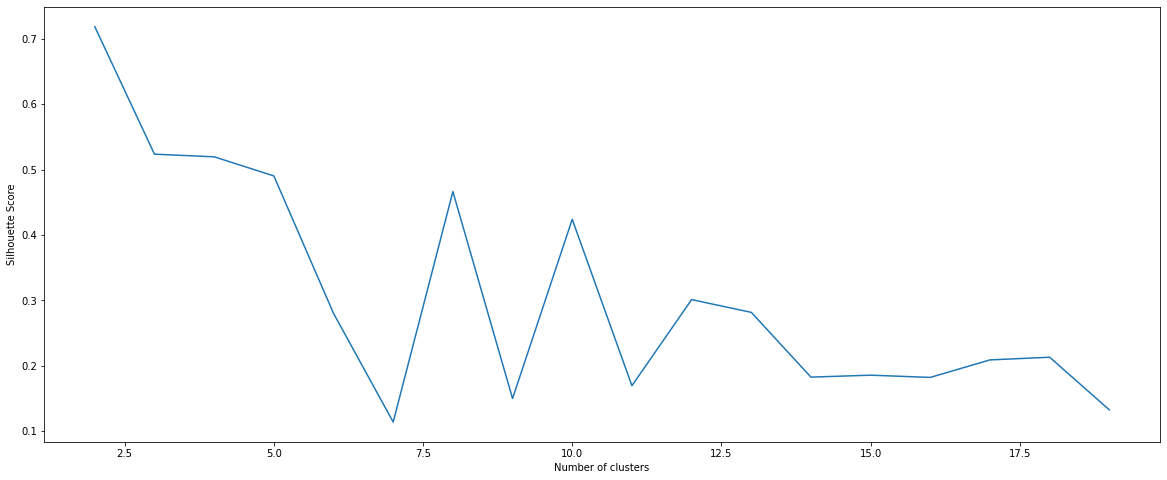

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(20,8))
ax.plot(range(2,20),silhouette_scores)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Score')

**Nhận xét (ClusteringEvaluator):**</br>
Ở lần thực thi hiện tại, biểu đồ Clustering Evaluator cho thấy các giá trị $k$ (số cluster) phù hợp với tập dữ liệu này có Silhouette score cao nhất là $k=2,4,6,7,8$ (xếp theo thứ tự giảm dần)</br>
Silhouette score: là giá trị tổng thể cho biết các điểm dữ liệu được phân bố vào đúng cụm của nó

**Clustering với $k=2$**

In [56]:
kmeans = KMeans(k=2, seed=1)
model = kmeans.fit(new_df.select('features'))
transformed = model.transform(new_df)
cluster = transformed.select('plant','prediction')

Thống kê số lượng mẫu thuộc các cluster

In [57]:
cluster.groupby('prediction').count().orderBy('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|30023|
|         1| 4758|
+----------+-----+



**Clustering với $k=4$**

In [58]:
kmeans = KMeans(k=4, seed=1)
model = kmeans.fit(new_df.select('features'))
transformed = model.transform(new_df)
cluster = transformed.select('plant','prediction')

Thống kê số lượng mẫu thuộc các cluster

In [59]:
cluster.groupby('prediction').count().orderBy('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|25151|
|         1| 3240|
|         2| 3262|
|         3| 3128|
+----------+-----+



# Hết